## Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy import stats
import glob
import re
from scipy import stats
from scipy.stats import wilcoxon

import pickle
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec


## Create Heatmap Displays

PHQ8_NoInterest:
  Absolute Average Difference: 0.667
  Number of N/A Questions: 29
  Accuracy on Available Questions: 0.667
  Overall Accuracy: 0.195
--------------------------------------------------
PHQ8_Depressed:
  Absolute Average Difference: 0.600
  Number of N/A Questions: 11
  Accuracy on Available Questions: 0.600
  Overall Accuracy: 0.439
--------------------------------------------------
PHQ8_Sleep:
  Absolute Average Difference: 0.825
  Number of N/A Questions: 1
  Accuracy on Available Questions: 0.825
  Overall Accuracy: 0.805
--------------------------------------------------
PHQ8_Tired:
  Absolute Average Difference: 0.957
  Number of N/A Questions: 18
  Accuracy on Available Questions: 0.957
  Overall Accuracy: 0.537
--------------------------------------------------
PHQ8_Appetite:
  Absolute Average Difference: 0.667
  Number of N/A Questions: 38
  Accuracy on Available Questions: 0.667
  Overall Accuracy: 0.049
--------------------------------------------------
PHQ8

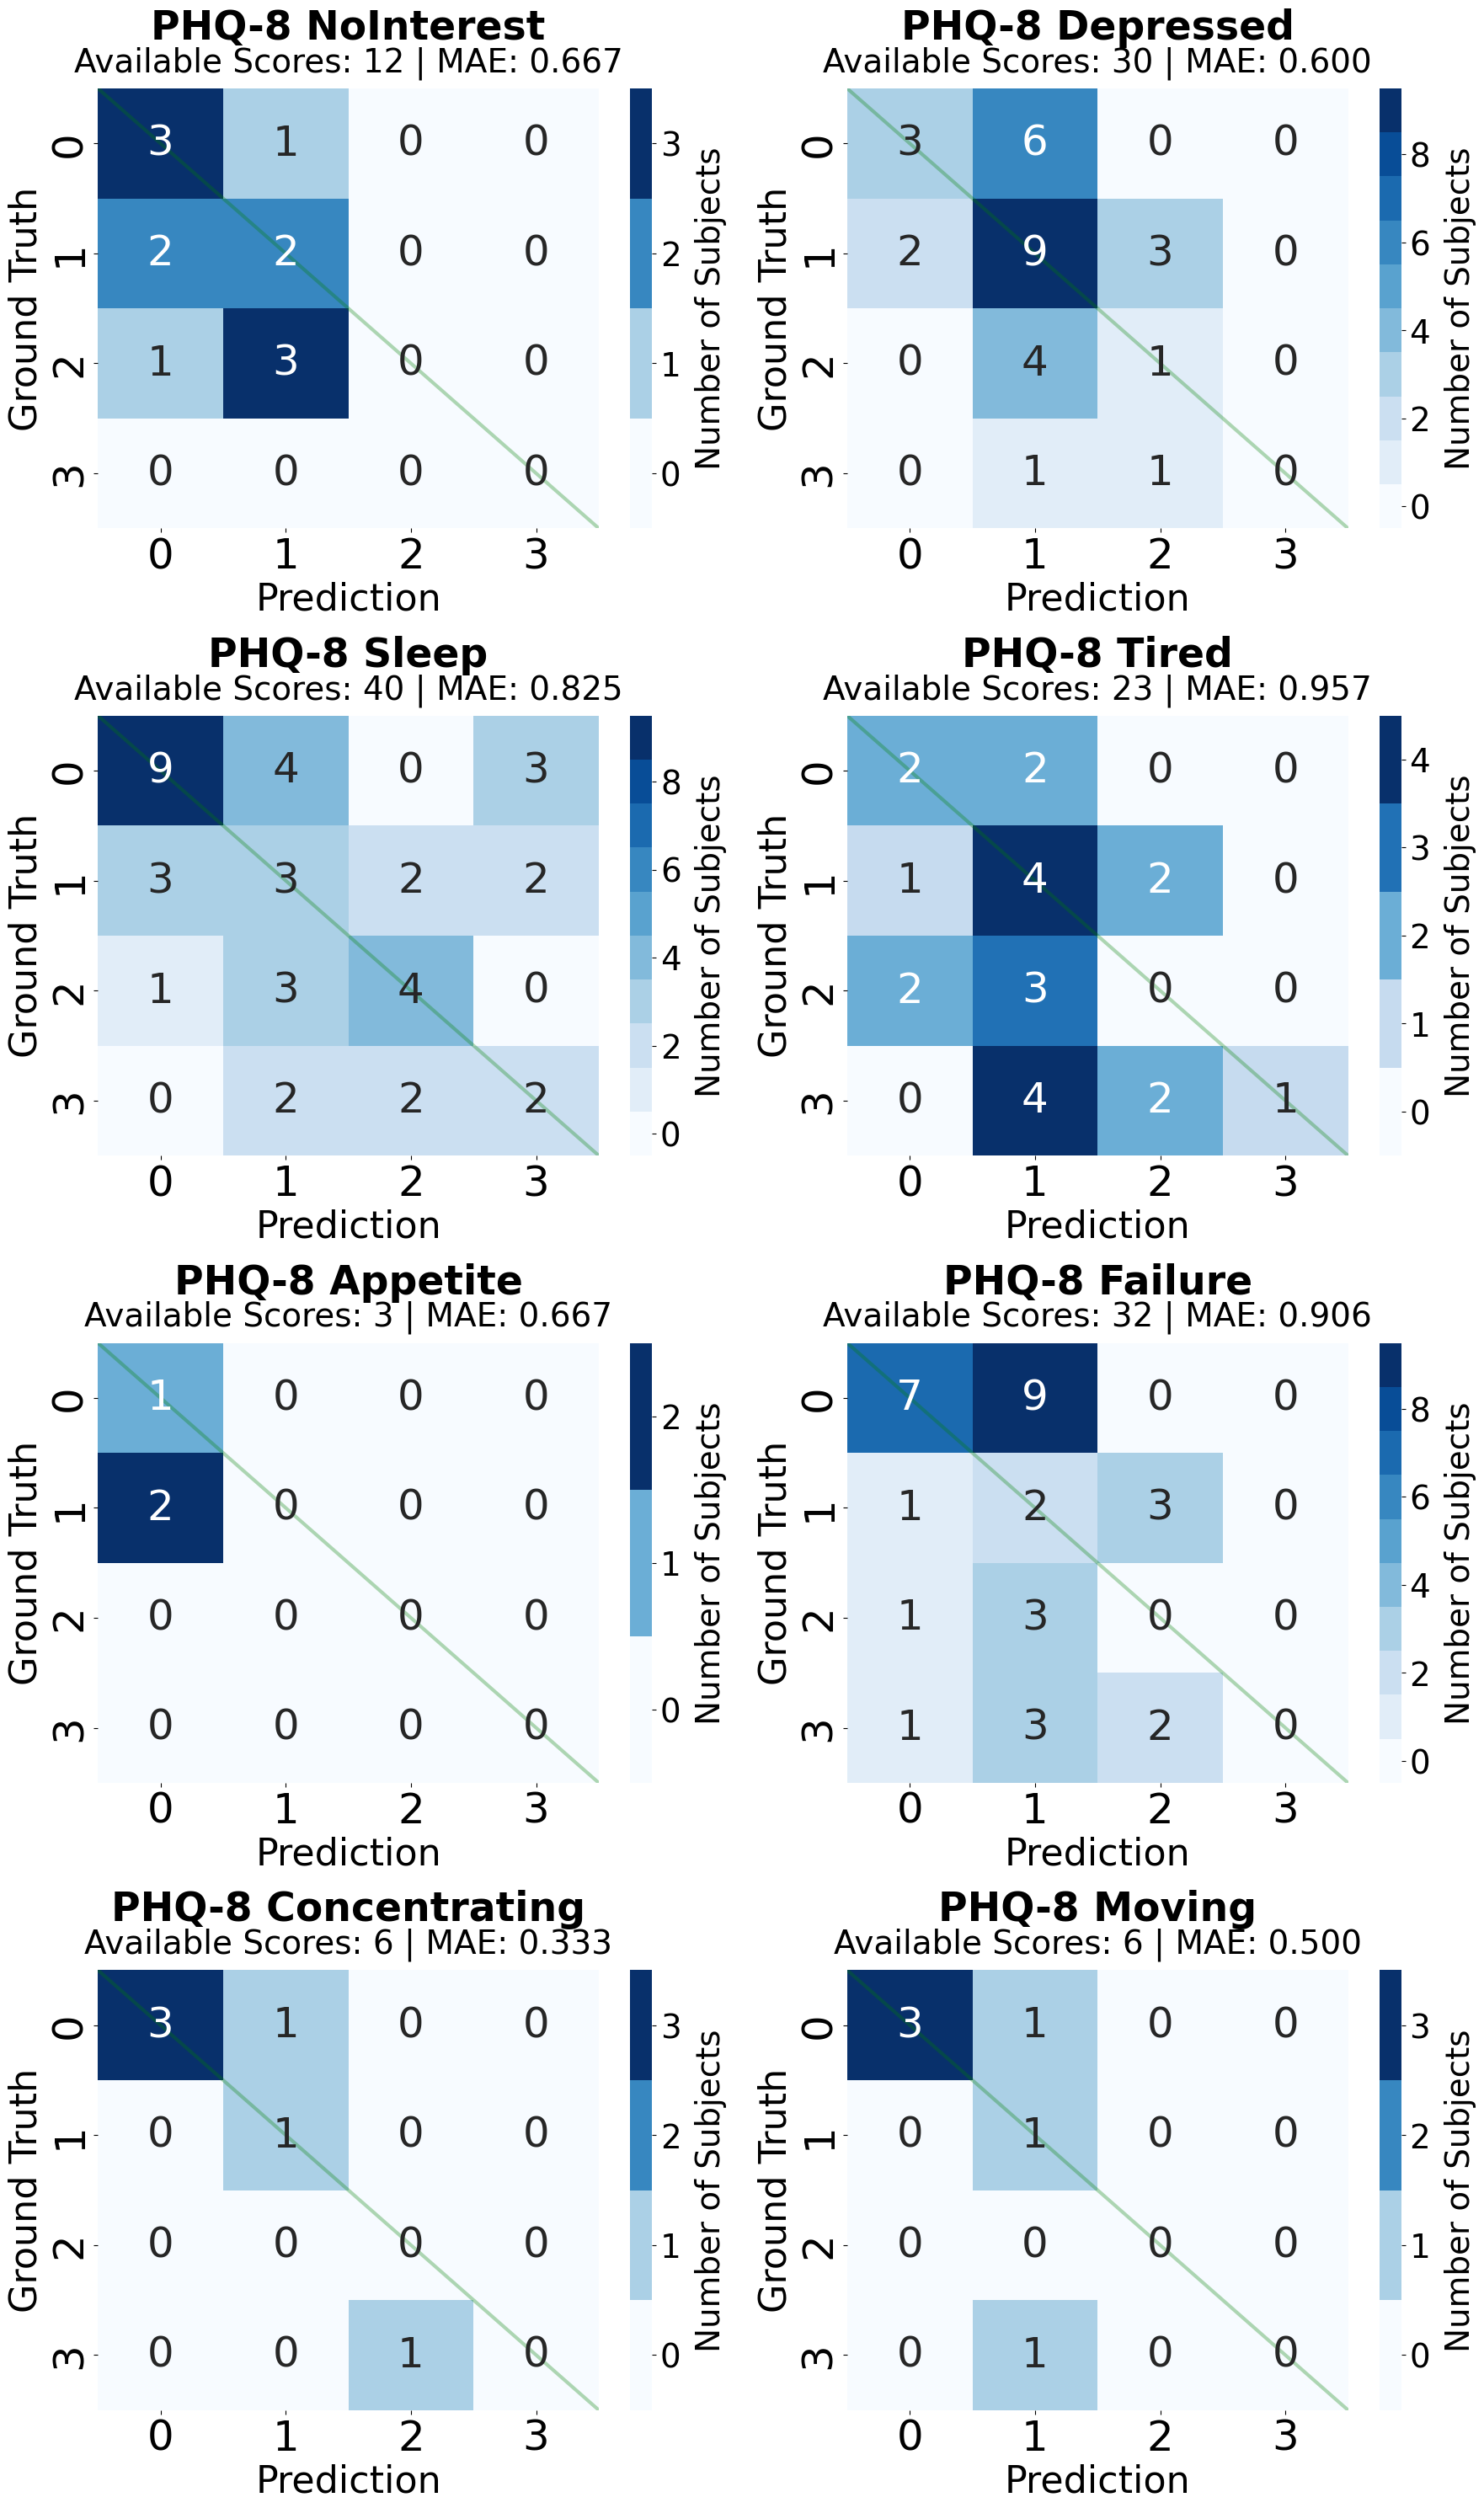

In [ ]:
def load_jsonl(file_path):
    """
    Loads the jsonl file

    Parameters
    ----------
    file_path : string
        The path to the jsonl file

    Returns
    -------
    list
        A list of dictionaries, where each dictionary represents 
        a JSON object from a line in the JSONL file
    """
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def load_ground_truth(csv_file1, csv_file2):
    """
    Loads and combines two CSV files containing ground truth data

    Parameters
    ----------
    csv_file1 : string
        Path to the first CSV file
    csv_file2 : string
        Path to the second CSV file

    Returns
    -------
    pandas dataframe
        A combined dataframe containing data from both CSV files
    """
    df1 = pd.read_csv(csv_file1)
    df2 = pd.read_csv(csv_file2)
    # Combine the csv files together instead of switching back and forth for participants
    combined_df = pd.concat([df1, df2], ignore_index=True)
    return combined_df

few_shot_data = load_jsonl(r"/data/users2/agreene46/ai-psychiatrist/new_jsonl_analysis_output/ids_chunk_8_step_2_dim_4096_examples_2_embedding_results_analysis_1.jsonl")

predicted_data = few_shot_data
ground_truth_df = load_ground_truth(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv", r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")

# PHQ8 question names
phq8_questions = [
    'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
    'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
]

def extract_scores_for_question(predicted_data, ground_truth_df, question):
    """
    Grabs predicted and ground truth scores for a given PHQ8 question

    Parameters
    ----------
    predicted_data : list
        List of dictionaries containing predicted scores for participants
    ground_truth_df : pandas dataframe
        DataFrame containing ground truth scores with participant IDs
    question : string
        Name of the PHQ8 question to extract scores for

    Returns
    -------
    tuple
        A tuple containing:
        - predicted_scores (list): List of predicted scores as integers
        - ground_truth_scores (list): List of ground truth scores
        - participant_ids (list): List of participant IDs for matched entries
        - na_count (int): Number of entries with N/A predicted scores
    """

    predicted_scores = []
    ground_truth_scores = []
    participant_ids = []
    na_count = 0
    
    for entry in predicted_data:
        participant_id = entry['participant_id']
        
        gt_row = ground_truth_df[ground_truth_df['Participant_ID'] == participant_id]
        
        if not gt_row.empty:
            if question in entry:
                question_data = entry[question]
                score = question_data.get('score', 'N/A')
                
                if score == "N/A":
                    na_count += 1
                    continue
                else:
                    pred_score = int(score)
            else:
                na_count += 1
                continue
            
            # Get ground truth score
            gt_score = gt_row.iloc[0][question]
            
            predicted_scores.append(pred_score)
            ground_truth_scores.append(gt_score)
            participant_ids.append(participant_id)
    
    return predicted_scores, ground_truth_scores, participant_ids, na_count

def create_heatmap_with_na(predicted_scores, ground_truth_scores, question_name, na_count):
    """
    Creates a confusion matrix and calculates accuracy metrics for predicted vs ground truth scores

    Parameters
    ----------
    predicted_scores : list
        List of predicted scores as integers
    ground_truth_scores : list
        List of ground truth scores as integers
    question_name : string
        Name of the question (used for labeling)
    na_count : int
        Number of N/A predictions for this question

    Returns
    -------
    tuple
        A tuple containing:
        - cm (numpy.ndarray): Confusion matrix for scores 0-3
        - na_count (int): Number of N/A predictions
        - accuracy_available (float): Accuracy MAE
    """
    # Filter out NaN values
    valid_indices = []
    for i in range(len(predicted_scores)):
        if not (pd.isna(predicted_scores[i]) or pd.isna(ground_truth_scores[i])):
            valid_indices.append(i)
    
    # Create filtered arrays with only valid (non-NaN) values
    filtered_predicted = [predicted_scores[i] for i in valid_indices]
    filtered_ground_truth = [ground_truth_scores[i] for i in valid_indices]
    
    # Only proceed if we have valid data
    if len(filtered_predicted) == 0:
        # Return empty confusion matrix and NaN accuracy if no valid data
        cm = np.zeros((4, 4), dtype=int)
        accuracy_available = np.nan
        return cm, na_count, accuracy_available
    
    cm = confusion_matrix(filtered_ground_truth, filtered_predicted, labels=[0, 1, 2, 3])
    
    predicted_array = np.array(filtered_predicted)
    ground_truth_array = np.array(filtered_ground_truth)
    absolute_differences = np.abs(predicted_array - ground_truth_array)
    avg_absolute_diff = np.mean(absolute_differences)
    accuracy_available = avg_absolute_diff
    
    return cm, na_count, accuracy_available

fig, axes = plt.subplots(4, 2, figsize=(18, 30))
axes = axes.flatten()

title_fontsize = 34
subtitle_fontsize = 28
label_fontsize = 32
tick_fontsize = 36
colorbar_fontsize = 28

for i, question in enumerate(phq8_questions):
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    
    cm, na_count, accuracy_available = create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)
    
    n_bins = np.max(cm) + 1 if np.max(cm) > 0 else 1
    cmap = plt.get_cmap('Blues', n_bins)
    
    # Create heatmap on the subplot with discrete colormap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=[0, 1, 2, 3], 
                yticklabels=[0, 1, 2, 3],
                ax=axes[i], annot_kws={'size': tick_fontsize})
    
    cbar = axes[i].collections[0].colorbar
    if n_bins > 1 and n_bins < 9:
        cbar.set_ticks(np.arange((n_bins-1)/(2*n_bins), n_bins-1, (n_bins-1)/n_bins))
        cbar.set_ticklabels(range(n_bins))
    elif n_bins >= 9:
        cbar.set_ticks(np.arange((n_bins-1)/(2*n_bins), n_bins-1, 2*(n_bins-1)/n_bins))
        cbar.set_ticklabels(range(0, n_bins, 2))
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    cbar.set_label('Number of Subjects', labelpad=12, fontsize=colorbar_fontsize)
    
    axes[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[i].set_xlabel('Prediction', fontsize=label_fontsize)
    axes[i].set_ylabel('Ground Truth', fontsize=label_fontsize)
    
    question_title = question.replace('PHQ8_', 'PHQ-8 ')
    total_with_gt = len(predicted_scores) + na_count
    available_scores = total_with_gt - na_count

    axes[i].set_title(question_title, fontsize=title_fontsize, fontweight='bold', pad=42)

    subtitle = f'Available Scores: {available_scores} | MAE: {accuracy_available:.3f}'
    axes[i].text(0.5, 1.02, subtitle, transform=axes[i].transAxes,
                ha='center', va='bottom', fontsize=subtitle_fontsize)
    
    axes[i].plot([4.5, -0.5], [4.5, -0.5], 'g-', linewidth=3, alpha=0.3)
    
    total_participants_with_gt = len(predicted_scores) + na_count
    percent_not_na = (total_participants_with_gt - na_count) / total_participants_with_gt
    overall_accuracy = accuracy_available * percent_not_na
    
    print(f"{question}:")
    print(f"  Absolute Average Difference: {np.mean(np.abs(np.array(predicted_scores) - np.array(ground_truth_scores))):.3f}")
    print(f"  Number of N/A Questions: {na_count}")
    print(f"  Accuracy on Available Questions: {accuracy_available:.3f}")
    print(f"  Overall Accuracy: {overall_accuracy:.3f}")
    print("-" * 50)

# Calculate and print overall averages
all_maes = []
all_na_counts = []

for question in phq8_questions:
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    
    cm, na_count, accuracy_available = create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)
    
    if not np.isnan(accuracy_available):
        all_maes.append(accuracy_available)
    all_na_counts.append(na_count)

print("=" * 50)
print("OVERALL AVERAGES:")
print(f"Total Average MAE across all questions: {np.mean(all_maes)}")
print(f"Total Average N/A Predictions per question: {np.mean(all_na_counts)}")
print("=" * 50)

plt.tight_layout(pad=1.5)
plt.savefig(r"/data/users2/agreene46/heatmap_output.pdf", bbox_inches='tight', dpi=300)

for question in phq8_questions:
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)

## MAE Zero Shot vs Few Shot Graph

Few-shot data: 41 entries
Few-shot unique participants: 41
Zero-shot data (filtered): 41 entries
Few-shot data: 41 entries
Few-shot unique participants: 41
Zero-shot data (filtered): 41 entries
Gemma 3 - Average Zero-shot MAE: 0.79594340
Gemma 3 - Average Few-shot MAE: 0.61929388
MedGemma - Average Zero-shot MAE: 0.55528665
MedGemma - Average Few-shot MAE: 0.50512610



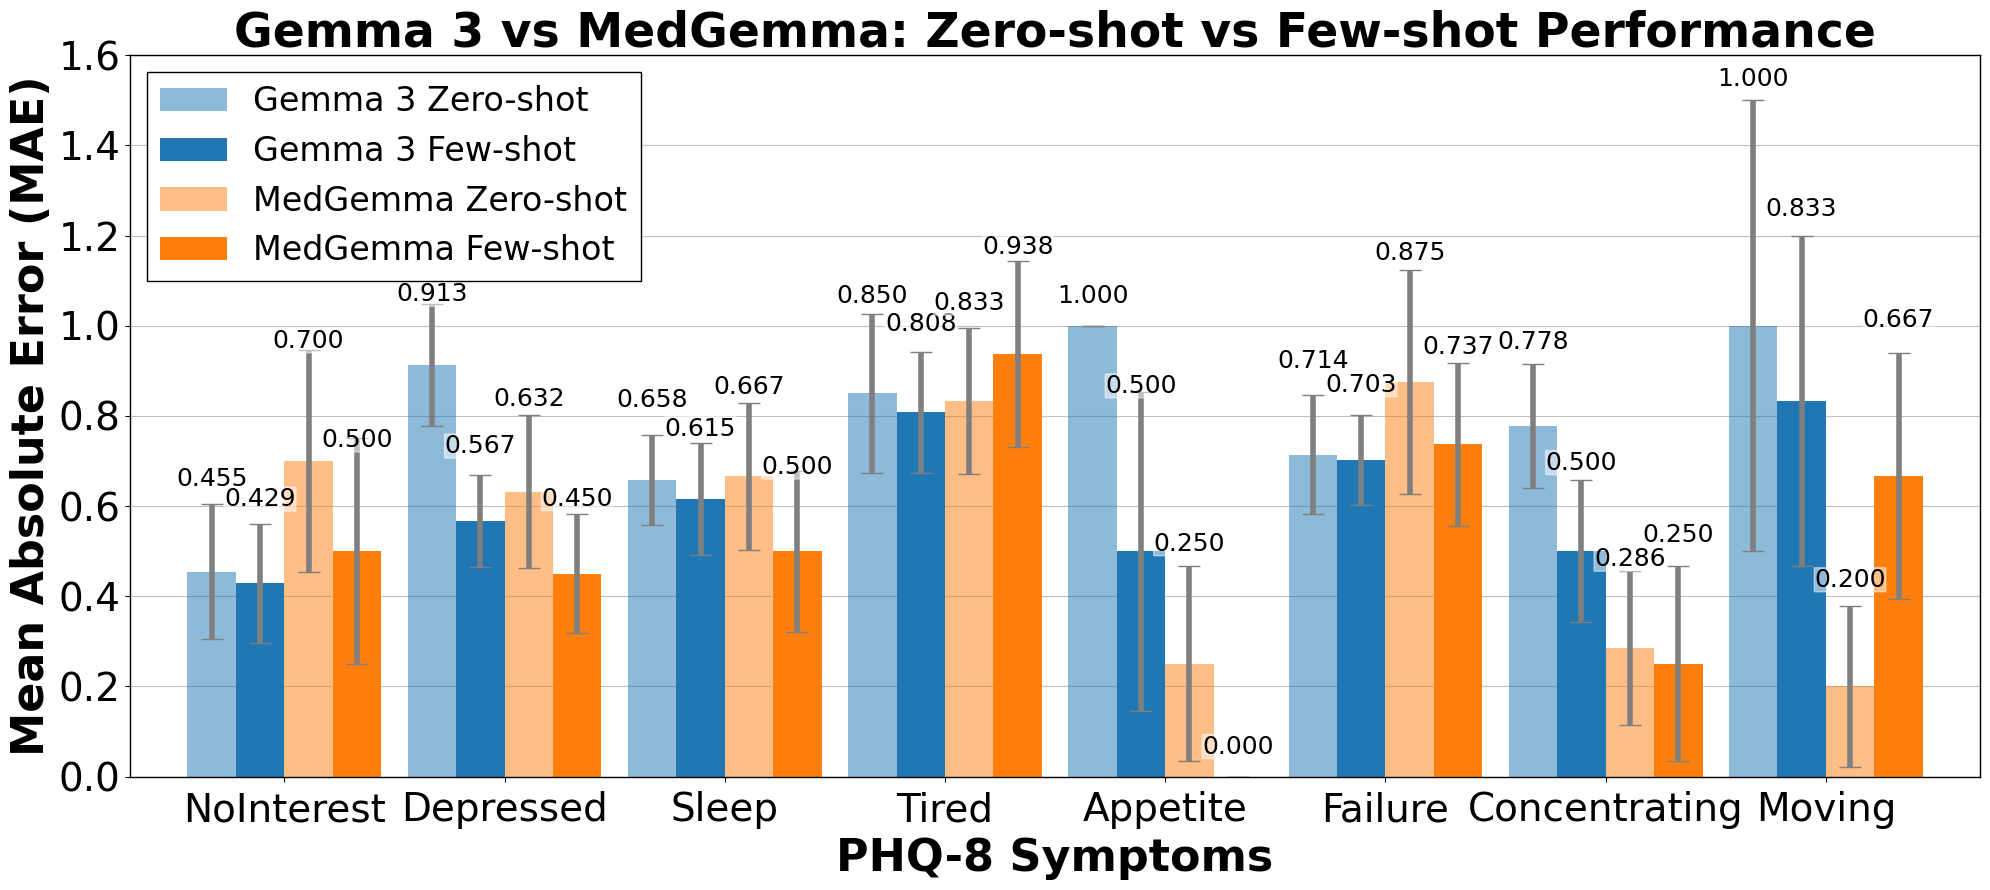

MAE Summary - Gemma 3:
--------------------------------------------------
NoInterest:
  Zero-shot MAE: 0.455 ± 0.150
  Few-shot MAE: 0.429 ± 0.132
  Improvement: 0.026
--------------------------------------------------
Depressed:
  Zero-shot MAE: 0.913 ± 0.136
  Few-shot MAE: 0.567 ± 0.102
  Improvement: 0.346
--------------------------------------------------
Sleep:
  Zero-shot MAE: 0.658 ± 0.100
  Few-shot MAE: 0.615 ± 0.124
  Improvement: 0.043
--------------------------------------------------
Tired:
  Zero-shot MAE: 0.850 ± 0.177
  Few-shot MAE: 0.808 ± 0.133
  Improvement: 0.042
--------------------------------------------------
Appetite:
  Zero-shot MAE: 1.000 ± 0.000
  Few-shot MAE: 0.500 ± 0.354
  Improvement: 0.500
--------------------------------------------------
Failure:
  Zero-shot MAE: 0.714 ± 0.132
  Few-shot MAE: 0.703 ± 0.100
  Improvement: 0.012
--------------------------------------------------
Concentrating:
  Zero-shot MAE: 0.778 ± 0.139
  Few-shot MAE: 0.500 ± 0.

In [ ]:
def load_jsonl_filtered(few_shot_path, zero_shot_path):
    """
    Load JSONL files with participant ID filtering.
    First loads few-shot data, then loads only matching participants from zero-shot data.
    
    Args:
        few_shot_path: Path to few-shot JSONL file
        zero_shot_path: Path to zero-shot JSONL file
    
    Returns:
        tuple: (few_shot_data, filtered_zero_shot_data)
    """
    # Load few-shot data
    few_shot_data = []
    with open(few_shot_path, 'r') as f:
        for line in f:
            few_shot_data.append(json.loads(line))
    
    # Extract participant IDs from few-shot data
    few_shot_participant_ids = set()
    for entry in few_shot_data:
        few_shot_participant_ids.add(entry['participant_id'])
    
    # Load zero-shot data, filtering by participant IDs
    filtered_zero_shot_data = []
    with open(zero_shot_path, 'r') as f:
        for line in f:
            entry = json.loads(line)
            if entry['participant_id'] in few_shot_participant_ids:
                filtered_zero_shot_data.append(entry)
    
    print(f"Few-shot data: {len(few_shot_data)} entries")
    print(f"Few-shot unique participants: {len(few_shot_participant_ids)}")
    print(f"Zero-shot data (filtered): {len(filtered_zero_shot_data)} entries")
    
    return few_shot_data, filtered_zero_shot_data

gemma3_few_shot_data, gemma3_zero_shot_data = load_jsonl_filtered(
    r"/data/users2/agreene46/ai-psychiatrist/TEST_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/analysis_output/zero_shot_results_detailed.jsonl"
)

medgemma_few_shot_data, medgemma_zero_shot_data = load_jsonl_filtered(
    r"/data/users2/agreene46/ai-psychiatrist/medgemma_analysis_output/chunk_8_step_2_dim_4096_examples_2_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/medgemma_analysis_output/zero_shot_results_analysis.jsonl"
)

def calculate_mae_and_se(zero_shot_data, few_shot_data, ground_truth_df, question):
    """
    Calculate Mean Absolute Error (MAE) and standard error for zero-shot and few-shot predictions.

    Args:
        zero_shot_data: List of dictionaries containing zero-shot predictions with participant IDs
        few_shot_data: List of dictionaries containing few-shot predictions with participant IDs
        ground_truth_df: DataFrame containing ground truth scores with 'Participant_ID' column
        question: String identifier for the specific question/metric to evaluate

    Returns:
        tuple: (zero_shot_mae, zero_shot_se, few_shot_mae, few_shot_se)
            - zero_shot_mae: Mean absolute error for zero-shot predictions
            - zero_shot_se: Standard error for zero-shot predictions  
            - few_shot_mae: Mean absolute error for few-shot predictions
            - few_shot_se: Standard error for few-shot predictions
            Returns np.nan for any metric if no valid predictions are available
    """
    zero_shot_dict = {}
    few_shot_dict = {}
    
    # Collect zero-shot predictions
    for entry in zero_shot_data:
        participant_id = entry['participant_id']
        if question in entry:
            score = entry[question].get('score', 'N/A')
            if score != "N/A":
                try:
                    zero_shot_dict[participant_id] = int(score)
                except ValueError:
                    continue
    
    # Collect few-shot predictions
    for entry in few_shot_data:
        participant_id = entry['participant_id']
        if question in entry:
            score = entry[question].get('score', 'N/A')
            if score != "N/A":
                try:
                    few_shot_dict[participant_id] = int(score)
                except ValueError:
                    continue
    
    # Calculate errors
    zero_shot_errors = []
    few_shot_errors = []
    
    # Calculate errors for zero-shot
    for participant_id, pred_score in zero_shot_dict.items():
        gt_row = ground_truth_df[ground_truth_df['Participant_ID'] == participant_id]
        if not gt_row.empty:
            ground_truth_score = gt_row[question].iloc[0]
            if not pd.isna(ground_truth_score):
                zero_shot_errors.append(abs(pred_score - ground_truth_score))
    
    # Calculate errors for few-shot
    for participant_id, pred_score in few_shot_dict.items():
        gt_row = ground_truth_df[ground_truth_df['Participant_ID'] == participant_id]
        if not gt_row.empty:
            ground_truth_score = gt_row[question].iloc[0]
            if not pd.isna(ground_truth_score):
                few_shot_errors.append(abs(pred_score - ground_truth_score))
    
    # Calculate MAE and SE using actual sample sizes
    zero_shot_mae = np.mean(zero_shot_errors) if zero_shot_errors else np.nan
    few_shot_mae = np.mean(few_shot_errors) if few_shot_errors else np.nan
    
    # Use actual number of valid responses for SE calculation
    zero_shot_n = len(zero_shot_errors)
    few_shot_n = len(few_shot_errors)
    
    zero_shot_se = np.std(zero_shot_errors) / np.sqrt(zero_shot_n) if zero_shot_n > 0 else np.nan
    few_shot_se = np.std(few_shot_errors) / np.sqrt(few_shot_n) if few_shot_n > 0 else np.nan
    
    return zero_shot_mae, zero_shot_se, few_shot_mae, few_shot_se


# Calculate MAE and SE for each question for both models
gemma3_zero_shot_maes = []
gemma3_zero_shot_ses = [] 
gemma3_few_shot_maes = []
gemma3_few_shot_ses = []

medgemma_zero_shot_maes = []
medgemma_zero_shot_ses = [] 
medgemma_few_shot_maes = []
medgemma_few_shot_ses = []

for question in phq8_questions:
    # Gemma 3 calculations
    zs_mae, zs_se, fs_mae, fs_se = calculate_mae_and_se(
        gemma3_zero_shot_data, gemma3_few_shot_data, ground_truth_df, question)
    gemma3_zero_shot_maes.append(zs_mae)
    gemma3_zero_shot_ses.append(zs_se) 
    gemma3_few_shot_maes.append(fs_mae)
    gemma3_few_shot_ses.append(fs_se)
    
    # MedGemma calculations
    zs_mae, zs_se, fs_mae, fs_se = calculate_mae_and_se(
        medgemma_zero_shot_data, medgemma_few_shot_data, ground_truth_df, question)
    medgemma_zero_shot_maes.append(zs_mae)
    medgemma_zero_shot_ses.append(zs_se) 
    medgemma_few_shot_maes.append(fs_mae)
    medgemma_few_shot_ses.append(fs_se)

print(f"Gemma 3 - Average Zero-shot MAE: {np.nanmean(gemma3_zero_shot_maes):.8f}")
print(f"Gemma 3 - Average Few-shot MAE: {np.nanmean(gemma3_few_shot_maes):.8f}")
print(f"MedGemma - Average Zero-shot MAE: {np.nanmean(medgemma_zero_shot_maes):.8f}")
print(f"MedGemma - Average Few-shot MAE: {np.nanmean(medgemma_few_shot_maes):.8f}")
print()

fig, ax = plt.subplots(figsize=(20, 9))

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

x = np.arange(len(phq8_questions))
width = 0.22

gemma3_color = '#1f77b4'  # Blue
medgemma_color = '#ff7f0e'  # Orange
error_bar_color = '#7f7f7f'  # Gray

# 4 bar groups: Gemma3 Zero-shot, MedGemma Zero-shot, Gemma3 Few-shot, MedGemma Few-shot
bars1 = ax.bar(x - 1.5*width, gemma3_zero_shot_maes, width, label='Gemma 3 Zero-shot', 
               color=gemma3_color, alpha=0.5, yerr=gemma3_zero_shot_ses, capsize=8, 
               error_kw={'ecolor': error_bar_color, 'elinewidth': 4})
bars2 = ax.bar(x - 0.5*width, gemma3_few_shot_maes, width, label='Gemma 3 Few-shot', 
               color=gemma3_color, alpha=1.0, yerr=gemma3_few_shot_ses, capsize=8,
               error_kw={'ecolor': error_bar_color, 'elinewidth': 4})
bars3 = ax.bar(x + 0.5*width, medgemma_zero_shot_maes, width, label='MedGemma Zero-shot', 
               color=medgemma_color, alpha=0.5, yerr=medgemma_zero_shot_ses, capsize=8,
               error_kw={'ecolor': error_bar_color, 'elinewidth': 4})
bars4 = ax.bar(x + 1.5*width, medgemma_few_shot_maes, width, label='MedGemma Few-shot', 
               color=medgemma_color, alpha=1.0, yerr=medgemma_few_shot_ses, capsize=8,
               error_kw={'ecolor': error_bar_color, 'elinewidth': 4})

# Formatting
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=32, fontweight='bold')
ax.set_xlabel('PHQ-8 Symptoms', fontsize=32, fontweight='bold', labelpad=40)
ax.set_title('Gemma 3 vs MedGemma: Zero-shot vs Few-shot Performance', fontsize=34, fontweight='bold')
ax.set_xticks(x)
ax.tick_params(axis='x', which='both', labelbottom=False)
ax.set_ylim(bottom=0, top=1.6)
ax.set_xlim(-0.7, len(phq8_questions) - 0.3) 

clean_labels = [label.replace('PHQ8_', '') for label in phq8_questions]

# Staggered y-positions to better fit labels [Currently not used]
label_y_positions = []
for i in range(len(clean_labels)):
    if i % 2 == 0:
        label_y_positions.append(-0.02)  # Higher position
    else:
        label_y_positions.append(-0.02)  # Lower position

# Custom positioned labels
for i, label in enumerate(clean_labels):
    ax.text(i, label_y_positions[i], label, 
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=28)

ax.tick_params(axis='y', labelsize=28)

legend = ax.legend(fontsize=24, frameon=True, fancybox=False, 
                   edgecolor='black', facecolor='white', framealpha=1, loc='upper left')
legend.get_frame().set_linewidth(1)

ax.grid(axis='y', alpha=0.5, color='grey', linestyle='-', linewidth=0.8)
ax.set_axisbelow(True) # Put grid behind bars

# Vertical offsets for each question (gemma3_zero, gemma3_few, medgemma_zero, medgemma_few)
question_offsets = [
    (0.18, 0.16, 0.25, 0.25),   # NoInterest
    (0.13, 0.14, 0.18, 0.14),  # Depression
    (0.15, 0.13, 0.17, 0.19),   # Sleep
    (0.19, 0.17, 0.2, 0.21),  # Tired
    (0.04, 0.37, 0.24, 0.04),  # Appetite
    (0.18, 0.14, 0.26, 0.19),   # Failure
    (0.16, 0.17, 0.18, 0.27),   # Concentrating
    (0.52, 0.4, 0.21, 0.32),  # Moving
]

# Value labels on bars with individual vertical offsets
for i, bars in enumerate([bars1, bars2, bars3, bars4]):
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if not np.isnan(height):
            current_offset = question_offsets[j][i]
            ax.text(bar.get_x() + bar.get_width()/2., height + current_offset,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=18, 
                    bbox=dict(boxstyle='round,pad=0', 
                   facecolor='white', edgecolor='white', alpha=0.5))

plt.tight_layout()
plt.savefig(r"/data/users2/agreene46/bar_graphoutput.pdf", bbox_inches='tight', dpi=300)
plt.show()

print("MAE Summary - Gemma 3:")
print("-" * 50)
for i, question in enumerate(phq8_questions):
    clean_question = question.replace('PHQ8_', '')
    print(f"{clean_question}:")
    print(f"  Zero-shot MAE: {gemma3_zero_shot_maes[i]:.3f} ± {gemma3_zero_shot_ses[i]:.3f}")
    print(f"  Few-shot MAE: {gemma3_few_shot_maes[i]:.3f} ± {gemma3_few_shot_ses[i]:.3f}")
    print(f"  Improvement: {gemma3_zero_shot_maes[i] - gemma3_few_shot_maes[i]:.3f}")
    print("-" * 50)

print("\nMAE Summary - MedGemma:")
print("-" * 50)
for i, question in enumerate(phq8_questions):
    clean_question = question.replace('PHQ8_', '')
    print(f"{clean_question}:")
    print(f"  Zero-shot MAE: {medgemma_zero_shot_maes[i]:.3f} ± {medgemma_zero_shot_ses[i]:.3f}")
    print(f"  Few-shot MAE: {medgemma_few_shot_maes[i]:.3f} ± {medgemma_few_shot_ses[i]:.3f}")
    print(f"  Improvement: {medgemma_zero_shot_maes[i] - medgemma_few_shot_maes[i]:.3f}")
    print("-" * 50)

## MAE and N/A Heatmaps for all PHQ8 Results

Processed: chunk_4_examples_1 - MAE: 0.633, N/A: 0.742 (averaged from 3 files)
Processed: chunk_4_examples_2 - MAE: 0.592, N/A: 0.796 (averaged from 3 files)
Processed: chunk_4_examples_3 - MAE: 0.564, N/A: 0.829 (averaged from 3 files)
Processed: chunk_6_examples_1 - MAE: 0.587, N/A: 0.731 (averaged from 3 files)
Processed: chunk_6_examples_2 - MAE: 0.617, N/A: 0.744 (averaged from 3 files)
Processed: chunk_6_examples_3 - MAE: 0.674, N/A: 0.770 (averaged from 3 files)
Processed: chunk_8_examples_1 - MAE: 0.662, N/A: 0.762 (averaged from 3 files)
Processed: chunk_8_examples_2 - MAE: 0.554, N/A: 0.840 (averaged from 3 files)
Processed: chunk_8_examples_3 - MAE: 0.722, N/A: 0.821 (averaged from 3 files)


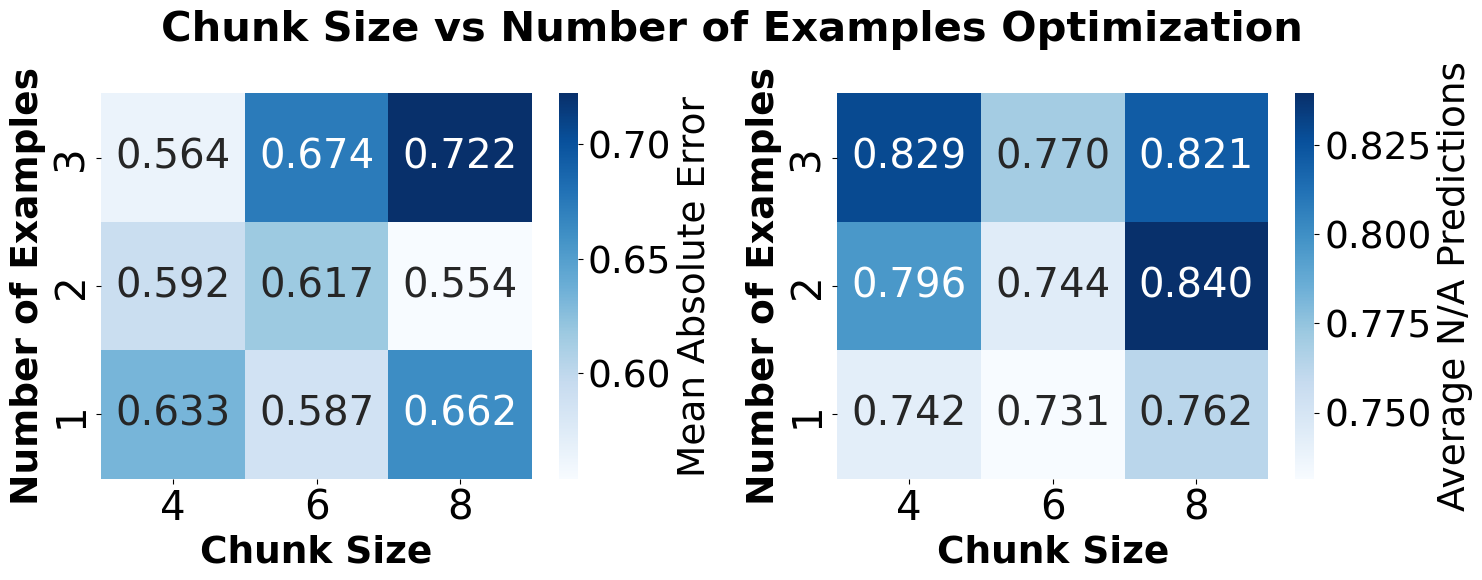

In [ ]:
def parse_filename(filename):
    """
    Extracts chunk size and number of examples from filename
    
    Parameters
    ----------
    filename : string
        Filename like "chunk_4_step_2_examples_1_embedding_results_analysis.jsonl"
    
    Returns
    -------
    tuple
        (chunk_size, number_of_examples) or (None, None) if parsing fails
    """
    pattern = r'chunk_(\d+)_step_\d+_examples_(\d+)_'
    match = re.search(pattern, filename)
    if match:
        chunk_size = int(match.group(1))
        num_examples = int(match.group(2))
        return chunk_size, num_examples
    return None, None

def calculate_overall_metrics(jsonl_file, ground_truth_df):
    """
    Calculates overall MAE and N/A count across all PHQ8 questions for a single file
    
    Parameters
    ----------
    jsonl_file : string
        Path to the JSONL file
    ground_truth_df : pandas dataframe
        DataFrame containing ground truth scores
    
    Returns
    -------
    tuple
        (mean_mae, total_na_count) across all questions
    """
    predicted_data = load_jsonl(jsonl_file)
    
    all_maes = []
    all_na_counts = []
    
    for question in phq8_questions:
        predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
            predicted_data, ground_truth_df, question
        )
        
        cm, na_count, accuracy_available = create_heatmap_with_na(
            predicted_scores, ground_truth_scores, question, na_count
        )
        
        if not np.isnan(accuracy_available):
            all_maes.append(accuracy_available)
        all_na_counts.append(na_count)
    
    mean_mae = np.mean(all_maes) if all_maes else np.nan
    total_na_count = np.sum(all_na_counts)
    
    return mean_mae, total_na_count

def create_comparison_heatmaps(jsonl_files, ground_truth_df, jsonl_files_2=None, jsonl_files_3=None):
    """
    Creates two 4x4 heatmaps comparing chunk_size vs number_of_examples
    
    Parameters
    ----------
    jsonl_files : list
        List of paths to JSONL files
    ground_truth_df : pandas dataframe
        DataFrame containing ground truth scores
    jsonl_files_2 : list, optional
        Second set of JSONL files to average with jsonl_files
    jsonl_files_3 : list, optional
        Third set of JSONL files to average with jsonl_files
    """
    # Define the ordering for chunk sizes and number of examples
    chunk_sizes = [4, 6, 8]
    num_examples = [1, 2, 3]
    
    mae_matrix = np.full((3, 3), np.nan)
    na_matrix = np.full((3, 3), np.nan)
    
    # Check if we need to average multiple file sets
    file_sets = [jsonl_files]
    if jsonl_files_2 is not None and len(jsonl_files_2) == len(jsonl_files):
        file_sets.append(jsonl_files_2)
    if jsonl_files_3 is not None and len(jsonl_files_3) == len(jsonl_files):
        file_sets.append(jsonl_files_3)
    
    # Process each file position across all sets
    for file_idx in range(len(jsonl_files)):
        files_to_average = [file_set[file_idx] for file_set in file_sets]
        
        # Parse filename from first file to get chunk_size and num_example
        filename = files_to_average[0].split('/')[-1]
        chunk_size, num_example = parse_filename(filename)
        
        if chunk_size and num_example:
            if chunk_size in chunk_sizes and num_example in num_examples:
                chunk_idx = chunk_sizes.index(chunk_size)
                example_idx = num_examples.index(num_example)
                
                # Calculate metrics for each file and average them
                mae_values = []
                na_values = []
                
                for jsonl_file in files_to_average:
                    mean_mae, total_na = calculate_overall_metrics(jsonl_file, ground_truth_df)
                    total_na = total_na/(27*8)
                    mae_values.append(mean_mae)
                    na_values.append(total_na)
                
                # Average the results
                avg_mae = np.mean(mae_values)
                avg_na = np.mean(na_values)
                
                mae_matrix[example_idx, chunk_idx] = avg_mae
                na_matrix[example_idx, chunk_idx] = avg_na
                
                print(f"Processed: chunk_{chunk_size}_examples_{num_example} - MAE: {avg_mae:.3f}, N/A: {avg_na:.3f} (averaged from {len(files_to_average)} files)")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Chunk Size vs Number of Examples Optimization', fontsize=30, fontweight='bold', y=0.98)
    
    # Mean Absolute Error
    sns.heatmap(mae_matrix, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=chunk_sizes,
                yticklabels=num_examples,
                ax=axes[0], annot_kws={'size': 29},
                cbar_kws={'label': 'Mean Absolute Error'})
    cbar = axes[0].collections[0].colorbar
    cbar.ax.tick_params(labelsize=27)
    cbar.set_label('Mean Absolute Error', fontsize=27)
    axes[0].tick_params(axis='both', which='major', labelsize=29)
    axes[0].set_xlabel('Chunk Size', fontsize=27, fontweight='bold')
    axes[0].set_ylabel('Number of Examples', fontsize=27, fontweight='bold')
    axes[0].invert_yaxis()
    
    # N/A Predictions
    sns.heatmap(na_matrix, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=chunk_sizes,
                yticklabels=num_examples,
                ax=axes[1], annot_kws={'size': 29},
                cbar_kws={'label': 'Average N/A Predictions'})
    cbar = axes[1].collections[0].colorbar
    cbar.ax.tick_params(labelsize=27)
    cbar.set_label('Average N/A Predictions', fontsize=27)
    axes[1].tick_params(axis='both', which='major', labelsize=29)
    axes[1].set_xlabel('Chunk Size', fontsize=27, fontweight='bold')
    axes[1].set_ylabel('Number of Examples', fontsize=27, fontweight='bold')
    axes[1].invert_yaxis()
    
    plt.tight_layout(pad=2.0)
    plt.savefig(r"/data/users2/agreene46/hyperparameter_matrix.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    
    return mae_matrix, na_matrix

# First jsonl files is the main one. 
# If you put equal amounts of jsonl files, in the same format within jsonl_files_2 and 3, it'll average them with the first files on the graph.
# To average 2 sets of files, you can leave jsonl_files_3 blank.

jsonl_files = [
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_1_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_2_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_3_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_1_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_2_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_3_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_1_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_3_embedding_results_analysis_1.jsonl",
]

jsonl_files_2 = [
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_1_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_2_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_3_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_1_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_2_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_3_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_1_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_3_embedding_results_analysis_2.jsonl",
]

jsonl_files_3 = [
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_1_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_2_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_4_step_2_examples_3_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_1_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_2_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_6_step_2_examples_3_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_1_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/VAL_analysis_output/chunk_8_step_2_examples_3_embedding_results_analysis_3.jsonl",
]

# Create the heatmaps
mae_matrix, na_matrix = create_comparison_heatmaps(jsonl_files, ground_truth_df, jsonl_files_2, jsonl_files_3)

## t-SNE Embeddings Visualization

Found 119 unique chunk IDs across all questions
Running t-SNE on 119 embeddings...


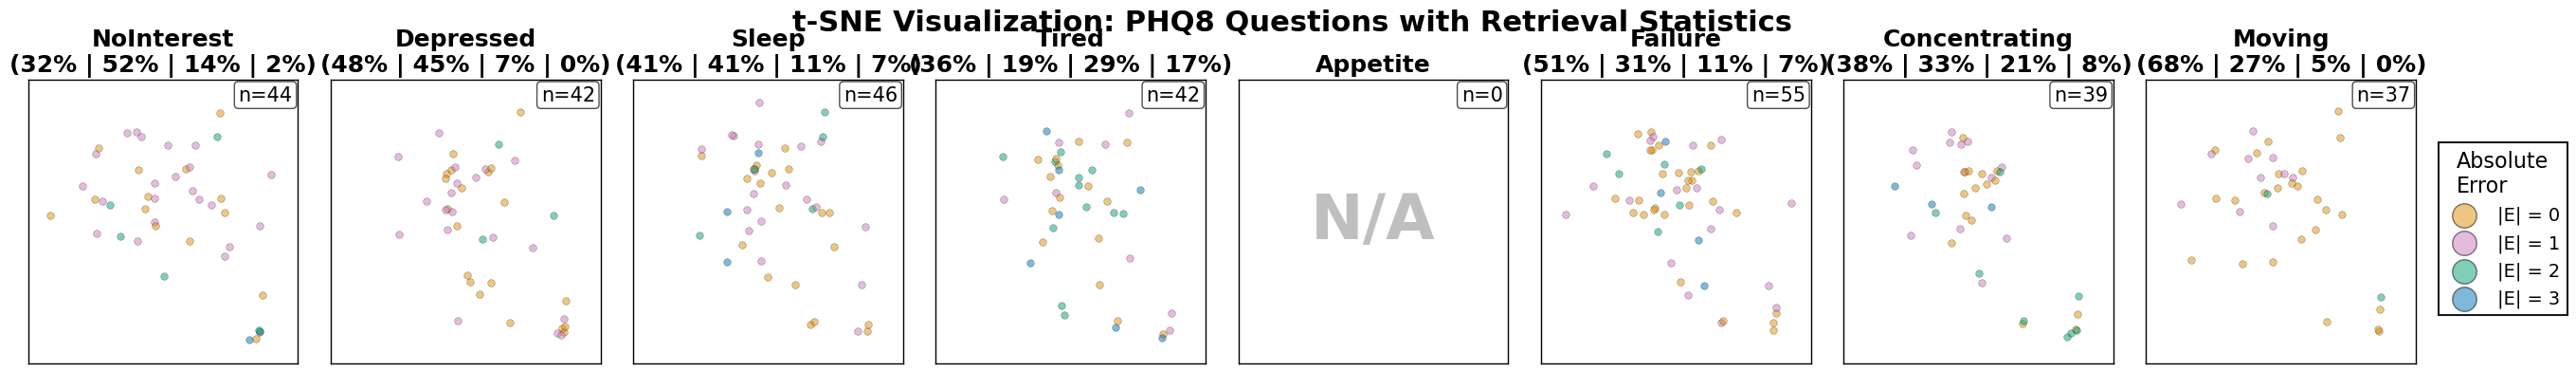


Detailed Summary by PHQ8 Question:
------------------------------------------------------------

PHQ8_NoInterest:
  Total chunks: 44
    Error 0:   14 chunks ( 31.8%)
    Error 1:   23 chunks ( 52.3%)
    Error 2:    6 chunks ( 13.6%)
    Error 3:    1 chunks (  2.3%)

PHQ8_Depressed:
  Total chunks: 42
    Error 0:   20 chunks ( 47.6%)
    Error 1:   19 chunks ( 45.2%)
    Error 2:    3 chunks (  7.1%)
    Error 3:    0 chunks (  0.0%)

PHQ8_Sleep:
  Total chunks: 46
    Error 0:   19 chunks ( 41.3%)
    Error 1:   19 chunks ( 41.3%)
    Error 2:    5 chunks ( 10.9%)
    Error 3:    3 chunks (  6.5%)

PHQ8_Tired:
  Total chunks: 42
    Error 0:   15 chunks ( 35.7%)
    Error 1:    8 chunks ( 19.0%)
    Error 2:   12 chunks ( 28.6%)
    Error 3:    7 chunks ( 16.7%)

PHQ8_Failure:
  Total chunks: 55
    Error 0:   28 chunks ( 50.9%)
    Error 1:   17 chunks ( 30.9%)
    Error 2:    6 chunks ( 10.9%)
    Error 3:    4 chunks (  7.3%)

PHQ8_Concentrating:
  Total chunks: 39
    Error 0:

In [ ]:
def extract_chunk_data_by_question(jsonl_path, phq8_ground_truths):
    """
    Extract chunk IDs and errors organized by PHQ8 question.
    
    Returns:
        dict: Nested dictionary {question: {chunk_id: error}}
    """
    chunk_data_by_question = {}
    
    phq8_questions = [
        'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
        'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
    ]
    
    # Initialize structure
    for question in phq8_questions:
        chunk_data_by_question[question] = {}
    
    with open(jsonl_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            participant_id = data['participant_id']
            
            # Get ground truth data for this participant
            participant_data = phq8_ground_truths.loc[
                phq8_ground_truths['Participant_ID'] == participant_id
            ]
            
            if participant_data.empty:
                continue
            
            # Process each PHQ8 question
            for question in phq8_questions:
                if question not in data:
                    continue
                
                question_data = data[question]
                
                # Skip if no reference IDs
                if 'reference_evidence_id' not in question_data or not question_data['reference_evidence_id']:
                    continue
                
                # Get ground truth score for this question
                ground_truth_score = participant_data[question].iloc[0]
                
                # Process each reference chunk
                reference_ids = question_data['reference_evidence_id']
                reference_scores = question_data.get('reference_evidence_scores', [])
                
                for i, chunk_id in enumerate(reference_ids):
                    if i < len(reference_scores):
                        ref_score = reference_scores[i]
                        error = abs(ref_score - ground_truth_score)
                        
                        # Store by question (keep minimum error if duplicate)
                        if chunk_id not in chunk_data_by_question[question] or error < chunk_data_by_question[question][chunk_id]:
                            chunk_data_by_question[question][chunk_id] = error
    
    return chunk_data_by_question

def visualize_tsne_grid(pkl_path, jsonl_path, phq8_ground_truths, n_iter=1000, 
                        perplexity=30, random_state=42):
    """
    Create 1x8 grid of t-SNE visualizations with retrieval statistics.
    
    Grid layout:
    - Single row with 8 columns (one per PHQ8 question)
    - Each plot shows all chunks for that question
    - Statistics show percentage breakdown by error level
    """
    # Extract chunk data organized by question
    chunk_data_by_question = extract_chunk_data_by_question(jsonl_path, phq8_ground_truths)
    
    # Load all embeddings
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    # Build global embedding dictionary
    embeddings_dict = {}
    participant_dict = {}
    global_chunk_id = 0
    
    for participant_id, chunks_array in data.items():
        for chunk_idx in range(len(chunks_array)):
            chunk_text, embedding_vector = chunks_array[chunk_idx]
            embeddings_dict[global_chunk_id] = embedding_vector
            participant_dict[global_chunk_id] = participant_id
            global_chunk_id += 1
    
    # Collect all unique chunk IDs from JSONL
    all_chunk_ids = set()
    for question_chunks in chunk_data_by_question.values():
        all_chunk_ids.update(question_chunks.keys())
    
    if not all_chunk_ids:
        print("No chunk IDs found in JSONL file")
        return
    
    print(f"Found {len(all_chunk_ids)} unique chunk IDs across all questions")
    
    # Prepare embeddings for t-SNE (using all chunks)
    embeddings_list = []
    chunk_id_list = []
    
    for chunk_id in sorted(all_chunk_ids):
        if chunk_id in embeddings_dict:
            embeddings_list.append(embeddings_dict[chunk_id])
            chunk_id_list.append(chunk_id)
    
    if not embeddings_list:
        print("No matching embeddings found")
        return
    
    # Run t-SNE once on all data
    embeddings_array = np.array(embeddings_list)
    n_samples = len(embeddings_array)
    adjusted_perplexity = min(perplexity, max(5, n_samples - 1))
    
    print(f"Running t-SNE on {n_samples} embeddings...")
    tsne = TSNE(
        n_components=2,
        metric='cosine',
        method='barnes_hut',
        n_iter=n_iter,
        perplexity=adjusted_perplexity,
        random_state=random_state,
        init='random'
    )
    embeddings_2d = tsne.fit_transform(embeddings_array)
    
    # Create mapping from chunk_id to t-SNE coordinates
    chunk_id_to_tsne = {}
    for i, chunk_id in enumerate(chunk_id_list):
        chunk_id_to_tsne[chunk_id] = embeddings_2d[i]

    fig = plt.figure(figsize=(29, 4.5), facecolor='white')
    
    # Create grid with extra space for legend
    gs = gridspec.GridSpec(2, 9, figure=fig, 
                          height_ratios=[4, 0.1],  # Main plots row, stats row
                          width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.4],  # 8 plots + legend
                          hspace=0.05, wspace=0.13, 
                          left=0.04, right=0.96,
                          top=0.79, bottom=0.08)
    
    # Define colors
    error_colors = {
        0: "#DE8F05",  # Minimal
        1: "#CC78BC",  # Mild error
        2: "#029E73",  # Moderate error
        3: "#0173B2",  # Mod-Severe error
    }
    
    phq8_questions = [
        'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
        'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
    ]
    
    # Use global axis limits for consistency
    x_min, x_max = embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max()
    y_min, y_max = embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max()
    x_margin = (x_max - x_min) * 0.1
    y_margin = (y_max - y_min) * 0.1
    
    # Plot each subplot
    for col_idx, question in enumerate(phq8_questions):
        question_chunks = chunk_data_by_question[question]
        
        # Main t-SNE plot
        ax = fig.add_subplot(gs[0, col_idx])
        ax.set_aspect('equal', adjustable='box')
        ax.set_facecolor('white')
        
        # Plot all chunks for this question
        if question_chunks:
            for chunk_id, error in question_chunks.items():
                if chunk_id in chunk_id_to_tsne:
                    point = chunk_id_to_tsne[chunk_id]
                    # Add small random jitter
                    jitter_x = np.random.normal(0, 0.02)
                    jitter_y = np.random.normal(0, 0.02)
                    ax.scatter(
                        point[0] + jitter_x, point[1] + jitter_y,
                        c=error_colors[error],
                        s=30,
                        alpha=0.5,
                        edgecolors='black',
                        linewidths=0.3
                    )
        else:
                if question == 'PHQ8_Appetite':
                    ax.text(0.5, 0.5, 'N/A', 
                        transform=ax.transAxes,
                        fontsize=48, 
                        ha='center', va='center',
                        color='gray',
                        alpha=0.5,
                        fontweight='bold')
        
        # Set consistent axis limits
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)
        
        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add border
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)
        
        # Add title (PHQ8 question name)
        ax.set_title(question.replace('PHQ8_', ''), fontsize=14, fontweight='bold')
        
        # Add total count annotation
        total_count = len(question_chunks)
        ax.text(0.98, 0.98, f'n={total_count}', transform=ax.transAxes,
               fontsize=15, ha='right', va='top',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # Calculate statistics first (move this before setting title)
        error_counts = {0: 0, 1: 0, 2: 0, 3: 0}
        for error in question_chunks.values():
            if error in error_counts:
                error_counts[error] += 1

        # Create title with percentages
        total_count = len(question_chunks)
        if total_count > 0:
            # Create percentage string for title
            perc_str = " | ".join([f"{(error_counts[e]/total_count)*100:.0f}%" for e in [0,1,2,3]])
            title = f"{question.replace('PHQ8_', '')}\n({perc_str})"
        else:
            title = question.replace('PHQ8_', '')

        # Add title (PHQ8 question name with percentages)
        ax.set_title(title, fontsize=18, fontweight='bold') 
                
        # Create statistics subplot
        stats_ax = fig.add_subplot(gs[1, col_idx])
        stats_ax.axis('off')
    
    # Add main title
    fig.suptitle('t-SNE Visualization: PHQ8 Questions with Retrieval Statistics', 
                fontsize=22, fontweight='bold', y=0.95)
    
    # Create legend in the rightmost area
    legend_ax = fig.add_subplot(gs[:, 8])
    legend_ax.axis('off')
    
    # Create legend elements
    legend_elements = []
    for error_val in sorted(error_colors.keys()):
        legend_elements.append(
            plt.scatter([], [], c=error_colors[error_val], s=150, alpha=0.5,
                    edgecolors='black', linewidths=1,
                    label=f'|E| = {error_val}')
        )
    
    legend = legend_ax.legend(
        handles=legend_elements,
        title='Absolute\nError',
        loc='center',
        frameon=True,
        fancybox=False,
        framealpha=0.9,
        fontsize=14,
        title_fontsize=16,
        markerscale=1.5
    )
    
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)
    
    # Save and show
    save_path = "/data/users2/agreene46/t-SNE_grid_visual_with_stats.pdf"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    # Print detailed summary statistics
    print("\nDetailed Summary by PHQ8 Question:")
    print("-" * 60)
    for question in phq8_questions:
        question_chunks = chunk_data_by_question[question]
        if question_chunks:
            errors = list(question_chunks.values())
            error_dist = pd.Series(errors).value_counts().sort_index()
            total = len(question_chunks)
            print(f"\n{question}:")
            print(f"  Total chunks: {total}")
            for error_val in [0, 1, 2, 3]:
                count = error_dist.get(error_val, 0)
                percentage = (count / total) * 100
                print(f"    Error {error_val}: {count:4d} chunks ({percentage:5.1f}%)")
    

dev_split_phq8 = pd.read_csv(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv")
train_split_phq8 = pd.read_csv(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")
phq8_ground_truths = pd.concat([dev_split_phq8, train_split_phq8], ignore_index=True)


visualize_tsne_grid(
    pkl_path=r"/data/users2/agreene46/ai-psychiatrist/chunk_8_step_2_dim_4096_participant_embedded_transcripts.pkl",
    jsonl_path=r"/data/users2/agreene46/ai-psychiatrist/new_jsonl_analysis_output/ids_chunk_8_step_2_dim_4096_examples_2_embedding_results_analysis_1.jsonl",
    phq8_ground_truths=phq8_ground_truths,
    n_iter=2000,
    perplexity=75
)

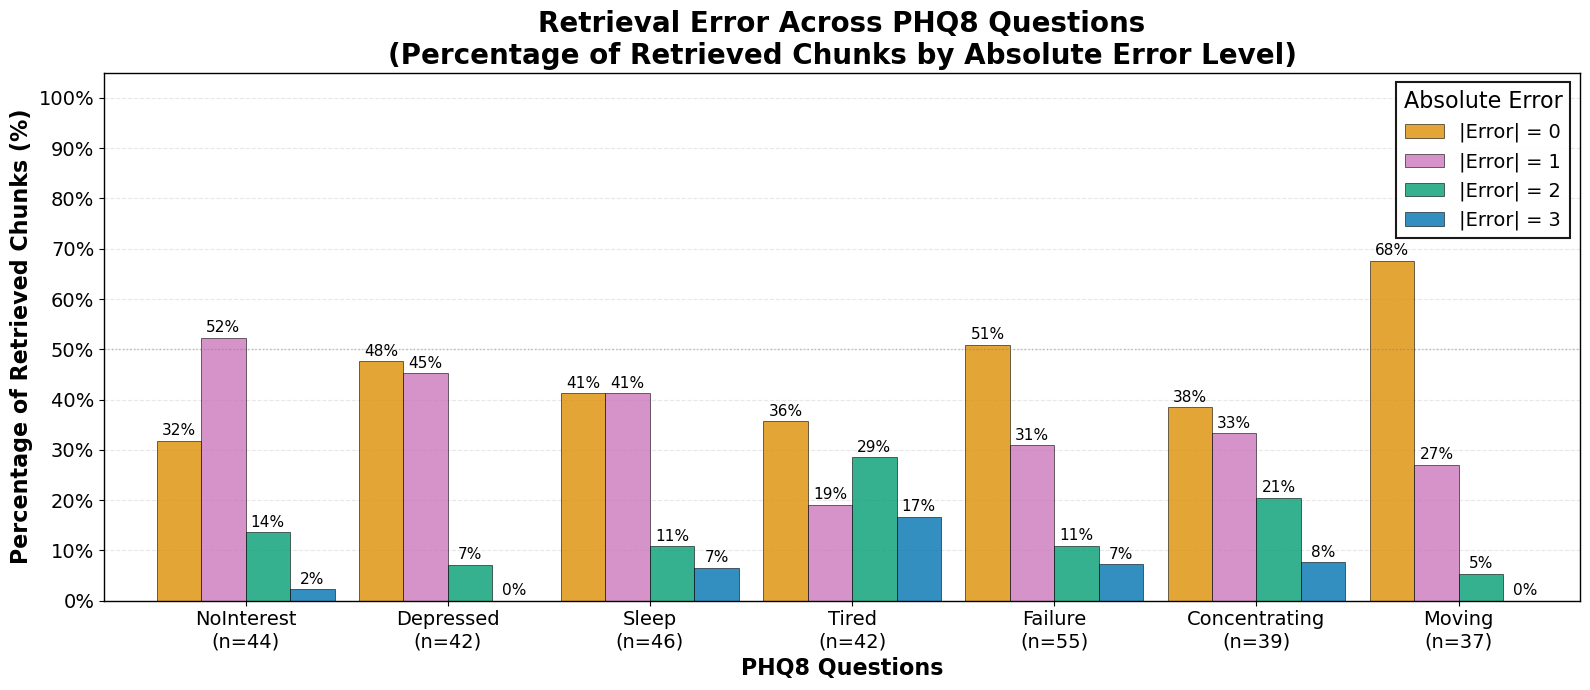


HISTOGRAM INTERPRETATION GUIDE

What to look for in this visualization:

1. ERROR DISTRIBUTION PATTERNS:
   - Orange bars (Error=0): Perfect matches between retrieval and ground truth
   - Pink bars (Error=1): Minor discrepancies (off by 1 point)
   - Green bars (Error=2): Moderate discrepancies (off by 2 points)
   - Blue bars (Error=3): Severe discrepancies (off by 3 points)

2. KEY OBSERVATIONS:

   BEST RETRIEVAL ACCURACY (highest Error=0 percentages):
   - Moving: 67.6% perfect matches
   - Failure: 50.9% perfect matches
   - Depressed: 47.6% perfect matches

   POOREST RETRIEVAL ACCURACY (lowest Error=0 percentages):
   - Concentrating: 38.5% perfect matches
   - Tired: 35.7% perfect matches
   - NoInterest: 31.8% perfect matches

   AVERAGE ERROR SCORES:
   Best (lowest average error):
   - Moving: 0.38
   - Depressed: 0.60
   - Failure: 0.75
   Worst (highest average error):
   - NoInterest: 0.86
   - Concentrating: 0.97
   - Tired: 1.26

3. CLINICAL IMPLICATIONS:
   - Symptom

In [ ]:
def create_error_histograms(jsonl_path, phq8_ground_truths):
    """
    Create histogram plot showing error distribution percentages for each PHQ8 question.
    """
    # Extract chunk data organized by question
    chunk_data_by_question = extract_chunk_data_by_question(jsonl_path, phq8_ground_truths)
    
    error_colors = {
        0: "#DE8F05",  # Minimal
        1: "#CC78BC",  # Mild error
        2: "#029E73",  # Moderate error
        3: "#0173B2",  # Severe error
    }
    
    phq8_questions = [
        'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
        'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
    ]
    phq8_questions = [q for q in phq8_questions if q != 'PHQ8_Appetite']
    
    # Prepare data for plotting
    question_labels = [q.replace('PHQ8_', '') for q in phq8_questions]
    
    # Calculate percentages for each error level
    error_percentages = {0: [], 1: [], 2: [], 3: []}
    total_chunks_per_question = []
    
    for question in phq8_questions:
        question_chunks = chunk_data_by_question[question]
        total = len(question_chunks)
        total_chunks_per_question.append(total)
        
        if total > 0:
            error_counts = {0: 0, 1: 0, 2: 0, 3: 0}
            for error in question_chunks.values():
                if error in error_counts:
                    error_counts[error] += 1
            
            for error_level in [0, 1, 2, 3]:
                percentage = (error_counts[error_level] / total) * 100
                error_percentages[error_level].append(percentage)
        else:
            # If no data, append 0 for all error levels
            for error_level in [0, 1, 2, 3]:
                error_percentages[error_level].append(0)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(16, 7), facecolor='white')
    ax.set_xlim(-0.7, len(question_labels) - 0.4)
    
    # Set up bar positions
    x = np.arange(len(question_labels))
    width = 0.22
    
    # Bars for each error level
    for i, error_level in enumerate([0, 1, 2, 3]):
        offset = (i - 1.5) * width
        bars = ax.bar(x + offset, error_percentages[error_level], width,
                      label=f'|Error| = {error_level}',
                      color=error_colors[error_level],
                      alpha=0.8,
                      edgecolor='black',
                      linewidth=0.5)
        
        # Add percentage labels on top of bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.0f}%',
                    ha='center', va='bottom', fontsize=11)
    
    ax.set_xlabel('PHQ-8 Symptoms', fontsize=16, fontweight='bold')
    ax.set_ylabel('Percentage of Retrieved Chunks (%)', fontsize=16, fontweight='bold')
    ax.set_title('Retrieval Error Across PHQ-8 Symptoms\n(Percentage of Retrieved Chunks by Absolute Error Level)',
                 fontsize=20, fontweight='bold')
    
    # Set x-axis
    ax.set_xticks(x)
    # Combine question labels with n= counts
    x_labels_with_n = [f'{label}\n(n={total})' for label, total in zip(question_labels, total_chunks_per_question)]
    ax.set_xticklabels(x_labels_with_n, fontsize=14)
    
    # Set y-axis
    ax.set_ylim(0, 105)
    ax.set_yticks(range(0, 101, 10))
    ax.set_yticklabels([f'{i}%' for i in range(0, 101, 10)], fontsize=14)
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Add legend
    legend = ax.legend(loc='upper right', frameon=True, fancybox=False,
                      framealpha=0.9, fontsize=14, title='Absolute Error',
                      title_fontsize=16)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)
    
    # Add a horizontal line at 50% for reference
    ax.axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Style the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.tight_layout()
    
    # Save the figure
    save_path = "/data/users2/agreene46/phq8_error_histograms.pdf"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("HISTOGRAM INTERPRETATION GUIDE")
    print("="*70)
    print("\nWhat to look for in this visualization:\n")
    
    print("1. ERROR DISTRIBUTION PATTERNS:")
    print("   - Orange bars (Error=0): Perfect matches between retrieval and ground truth")
    print("   - Pink bars (Error=1): Minor discrepancies (off by 1 point)")
    print("   - Green bars (Error=2): Moderate discrepancies (off by 2 points)")
    print("   - Blue bars (Error=3): Severe discrepancies (off by 3 points)")
    
    print("\n2. KEY OBSERVATIONS:")
    
    # Find symptoms with highest accuracy (Error=0)
    best_accuracy = [(q, error_percentages[0][i]) for i, q in enumerate(question_labels)]
    best_accuracy.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n   BEST RETRIEVAL ACCURACY (highest Error=0 percentages):")
    for symptom, percentage in best_accuracy[:3]:
        print(f"   - {symptom}: {percentage:.1f}% perfect matches")
    
    # Find symptoms with poorest accuracy
    print(f"\n   POOREST RETRIEVAL ACCURACY (lowest Error=0 percentages):")
    for symptom, percentage in best_accuracy[-3:]:
        print(f"   - {symptom}: {percentage:.1f}% perfect matches")
    
    # Calculate average error for each symptom
    avg_errors = []
    for i, question in enumerate(question_labels):
        if total_chunks_per_question[i] > 0:
            avg_error = sum(error_level * error_percentages[error_level][i] / 100 
                          for error_level in [0, 1, 2, 3])
            avg_errors.append((question, avg_error))
    
    avg_errors.sort(key=lambda x: x[1])
    
    print(f"\n   AVERAGE ERROR SCORES:")
    print(f"   Best (lowest average error):")
    for symptom, avg_err in avg_errors[:3]:
        print(f"   - {symptom}: {avg_err:.2f}")
    print(f"   Worst (highest average error):")
    for symptom, avg_err in avg_errors[-3:]:
        print(f"   - {symptom}: {avg_err:.2f}")
    
    print("\n3. CLINICAL IMPLICATIONS:")
    print("   - Symptoms with high Error=0 percentages indicate the retrieval system")
    print("     accurately identifies relevant text chunks for those symptoms")
    print("   - Symptoms with high Error=2 or Error=3 percentages suggest the system")
    print("     struggles to retrieve appropriate evidence for those symptoms")
    print("   - This could indicate:")
    print("     • Some symptoms are harder to detect from text")
    print("     • Training data may be imbalanced for certain symptoms")
    print("     • Certain symptoms may require more context than chunk size allows")
    
    print("\n4. NOTABLE PATTERNS:")
    # Check for N/A data
    if any(total == 0 for total in total_chunks_per_question):
        na_symptoms = [question_labels[i] for i, total in enumerate(total_chunks_per_question) if total == 0]
        print(f"   - No data available for: {', '.join(na_symptoms)}")
    
    # Check for symptoms with dominant error patterns
    for i, symptom in enumerate(question_labels):
        if total_chunks_per_question[i] > 0:
            for error_level in [0, 1, 2, 3]:
                if error_percentages[error_level][i] > 60:
                    print(f"   - {symptom} is dominated by Error={error_level} ({error_percentages[error_level][i]:.0f}%)")
    
    print("\n" + "="*70)
    
    return fig, ax

# Usage
fig, ax = create_error_histograms(
    jsonl_path=r"/data/users2/agreene46/ai-psychiatrist/new_jsonl_analysis_output/ids_chunk_8_step_2_dim_4096_examples_2_embedding_results_analysis_1.jsonl",
    phq8_ground_truths=phq8_ground_truths
)

Running t-SNE on 5040 embeddings...


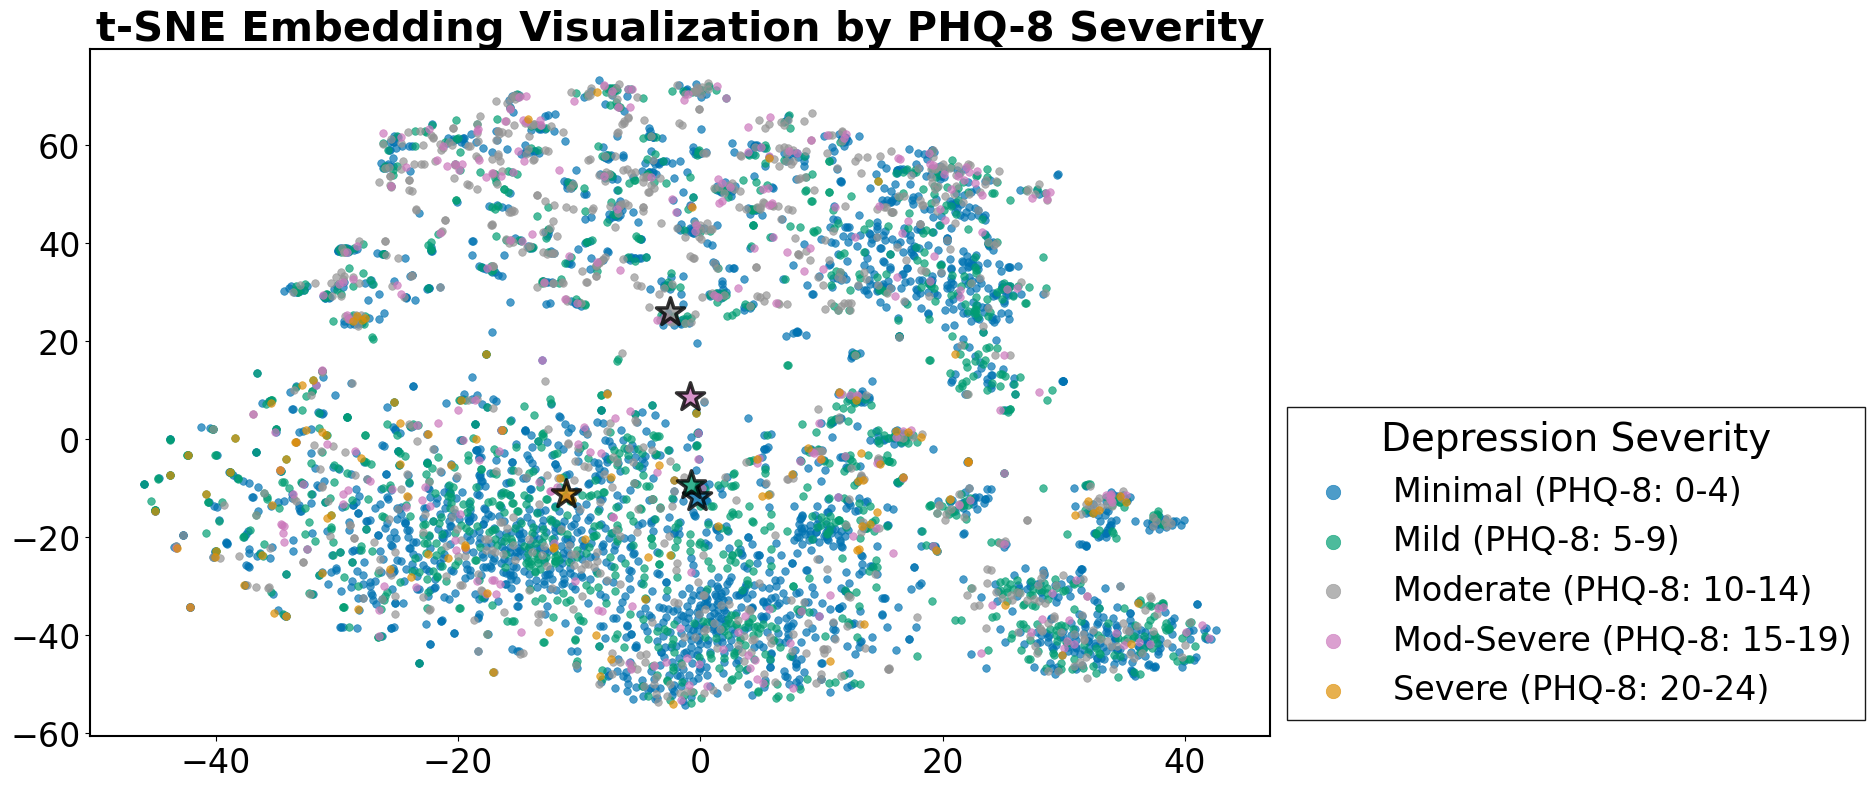


PHQ-8 Severity Distribution:
  Minimal: 2397 embeddings
  Mild: 1347 embeddings
  Moderate: 892 embeddings
  Mod-Severe: 290 embeddings
  Severe: 114 embeddings


In [ ]:
def load_embeddings_from_pkl(pkl_path):
    """
    Extract embeddings, labels, and texts from pickle file.
    
    Args:
        pkl_path: Path to pickle file containing participant embeddings data
    
    Returns:
        tuple: (embeddings_array, participant_labels, chunk_texts)
            - embeddings_array: NumPy array of embedding vectors
            - participant_labels: List of participant IDs for each embedding
            - chunk_texts: List of text chunks corresponding to each embedding
    """
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = []
    participant_labels = []
    chunk_texts = []
    
    for participant_id, chunks_array in data.items():
        for chunk_text, embedding_vector in chunks_array:
            embeddings.append(embedding_vector)
            participant_labels.append(participant_id)
            chunk_texts.append(chunk_text)
    
    return np.array(embeddings), participant_labels, chunk_texts

def get_phq8_severity(score):
    """
    Map PHQ-8 score to severity category.
    
    Args:
        score: PHQ-8 numerical score (0-24)
    
    Returns:
        str: Severity category ('Minimal', 'Mild', 'Moderate', 'Mod-Severe', 'Severe', or 'Unknown')
    """
    if 0 <= score <= 4:
        return 'Minimal'
    elif 5 <= score <= 9:
        return 'Mild'
    elif 10 <= score <= 14:
        return 'Moderate'
    elif 15 <= score <= 19:
        return 'Mod-Severe'
    elif 20 <= score <= 24:
        return 'Severe'
    else:
        return 'Unknown'

def visualize_tsne_with_phq8(pkl_path, phq8_ground_truths, n_iter=1000, perplexity=30, 
                              figsize=(15, 8), random_state=42):
    """
    Create and display t-SNE visualization of embeddings colored by PHQ-8 severity.
    
    Args:
        pkl_path: Path to pickle file containing embeddings
        phq8_ground_truths: DataFrame with 'Participant_ID' and 'PHQ8_Score' columns
        n_iter: Number of t-SNE iterations (default: 1000)
        perplexity: t-SNE perplexity parameter (default: 30)
        figsize: Figure size tuple (default: (12, 8))
        random_state: Random seed for reproducibility (default: 42)
    
    Returns:
        tuple: (embeddings_2d, participant_labels, severities, phq8_scores)
            - embeddings_2d: 2D t-SNE coordinates
            - participant_labels: List of participant IDs
            - severities: List of severity categories
            - phq8_scores: List of PHQ-8 scores
    """
    embeddings, participant_labels, chunk_texts = load_embeddings_from_pkl(pkl_path)
    
    # Map each embedding to PHQ-8 severity
    severities = []
    phq8_scores = []
    
    for participant_id in participant_labels:
        participant_data = phq8_ground_truths.loc[
            phq8_ground_truths['Participant_ID'] == participant_id
        ]
        
        if len(participant_data) > 0:
            phq8_score = participant_data['PHQ8_Score'].iloc[0]
            phq8_scores.append(phq8_score)
            severities.append(get_phq8_severity(phq8_score))
        else:
            phq8_scores.append(np.nan)
            severities.append('Unknown')
    
    # Perform t-SNE
    tsne = TSNE(
        n_components=2,
        metric='cosine',
        method='barnes_hut',
        n_iter=n_iter,
        perplexity=perplexity,
        random_state=random_state,
        init='random'
    )
    
    print(f"Running t-SNE on {len(embeddings)} embeddings...")
    embeddings_2d = tsne.fit_transform(embeddings)
    
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    ax.set_facecolor('white')
    
    severity_colors = {
        'Minimal': '#0173B2',           # Blue
        'Mild': '#029E73',              # Green
        'Moderate': '#949494',          # Grey
        'Mod-Severe': '#CC78BC', # Pink
        'Severe': '#DE8F05',            # Orange
        'Unknown': '#95a5a6'            # Gray
    }


    

    # Order for legend
    severity_order = ['Minimal', 'Mild', 'Moderate', 'Mod-Severe', 'Severe']
    
    # Dictionary to store centroids
    centroids = {}

    # Plot each severity level
    for severity in severity_order:
        if severity in severities:
            mask = np.array([s == severity for s in severities])
            severity_points = embeddings_2d[mask]
            
            ax.scatter(
                severity_points[:, 0],
                severity_points[:, 1],
                c=severity_colors[severity],
                label=f'{severity} (PHQ-8: {get_score_range(severity)})',
                alpha=0.7,
                s=30,
                edgecolors=severity_colors[severity],
                linewidths=0.5
            )
            
            # Calculate and plot centroid
            if len(severity_points) > 0:
                centroid = np.median(severity_points, axis=0)
                centroids[severity] = centroid
                
                ax.scatter(
                    centroid[0],
                    centroid[1],
                    c=severity_colors[severity],
                    s=450,
                    marker='*',
                    edgecolors='black',
                    linewidths=2.5,
                    zorder=10,
                    alpha=0.8,
                    label=None
                )
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(axis='both', which='major', labelsize=24)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    
    ax.set_title(
        f't-SNE Embedding Visualization by PHQ-8 Severity',
        fontsize=30,
        fontweight='bold'
    )
    
    legend = ax.legend(
        title='Depression Severity',
        loc='lower left',
        bbox_to_anchor=(1.00, 0),
        frameon=True,
        fancybox=False,
        framealpha=0.9,
        fontsize=24,
        title_fontsize=28,
        markerscale=1.9
    )

    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.savefig(r"/data/users2/agreene46/t-SNE_visual.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    
    print("\nPHQ-8 Severity Distribution:")
    severity_counts = pd.Series(severities).value_counts()
    for severity in severity_order:
        if severity in severity_counts.index:
            print(f"  {severity}: {severity_counts[severity]} embeddings")
    
    return embeddings_2d, participant_labels, severities, phq8_scores

def get_score_range(severity):
    """
    Get PHQ-8 score range for severity level.
    
    Args:
        severity: Severity category string
    
    Returns:
        str: Score range (e.g., '0-4') or 'N/A' if severity not found
    """
    ranges = {
        'Minimal': '0-4',
        'Mild': '5-9',
        'Moderate': '10-14',
        'Mod-Severe': '15-19',
        'Severe': '20-24'
    }
    return ranges.get(severity, 'N/A')

phq8_ground_truths = pd.concat([dev_split_phq8, train_split_phq8], ignore_index=True)

# Visualize with PHQ-8 severity coloring
embeddings_2d, labels, severities, scores = visualize_tsne_with_phq8(
    pkl_path=r"/data/users2/agreene46/ai-psychiatrist/chunk_8_step_2_dim_4096_participant_embedded_transcripts.pkl",
    phq8_ground_truths=phq8_ground_truths,
    n_iter=2000,
    perplexity=75
)